In [4]:
import time
import wave
import librosa
import librosa.display
import librosa.util
import librosa.filters
import librosa.display
from librosa.core import audio

import soundfile as sf
import soundfile

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from pydub import AudioSegment

import scipy
from scipy.io.wavfile import write
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt
from scipy.io import wavfile
from scipy.signal import fftconvolve

import random

import subprocess

import colorednoise as cn

import torch
import torchaudio

In [3]:

def RIR_Filtering(input_audio, output_audio, impulse_response_txt):

    # Read audio file
    sample_rate, audio_data = wavfile.read(input_audio)

    # Read impulse response samples from text file
    with open(impulse_response_txt, 'r') as f:
        impulse_response = np.array([float(line.strip()) for line in f.readlines()])

    # Apply convolution
    convolved_audio = fftconvolve(audio_data, impulse_response)#, mode='same')

    # Normalize the convolved audio
    convolved_audio = (convolved_audio / np.max(np.abs(convolved_audio)) * np.iinfo(np.int16).max).astype(np.int16)

    # Save the convolved audio to output file
    wavfile.write(output_audio, sample_rate, convolved_audio)

# Example usage:
RIR_Filtering('upc_ca_ona_100000.wav', 'upc_ca_ona_100000RIR.wav', '../program_samples/AIR_Database/air_binaural_aula_carolina_0_1_1_90_3.txt')



In [11]:
import torchaudio
import torchaudio.functional as F

def resample_audio(input_filename, target_sample_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Load the audio file
    waveform, sample_rate = torchaudio.load(input_filename)
    waveform = waveform.to(device)
    # Create a resample transform
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)

    # Apply the resample transform to the waveform
    resampled_waveform = resampler(waveform)

    return resampled_waveform, target_sample_rate


def RIR_Filtering(input_filename, output_filename, rir_filepath):
    # Load the audio and the RIR files
    waveform, sample_rate = torchaudio.load(input_filename)
    rir_raw, rir_sample_rate = torchaudio.load(rir_filepath)

    rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
    rir = rir / torch.linalg.vector_norm(rir, ord=2)


    # If the RIR file has a different sample rate, resample it
    if rir_sample_rate != sample_rate:
        rir_waveform, _ = resample_audio(rir_filepath, sample_rate)

    # Apply the RIR to the audio file
    #augmented_waveform = torch.nn.functional.conv1d(waveform[None, :], rir_waveform[None, :])[0]

    augmented_waveform = F.fftconvolve(waveform[None, :], rir_waveform[None, :])
    # Save the augmented audio to the output file
    torchaudio.save(output_filename, augmented_waveform, sample_rate)


RIR_Filtering('upc_ca_ona_100000.wav', 'upc_ca_ona_100000RIR.wav', '../program_samples/AIR_Database/air_binaural_aula_carolina_0_1_1_90_3.txt')



RuntimeError: Source stream index out of range

In [2]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

    

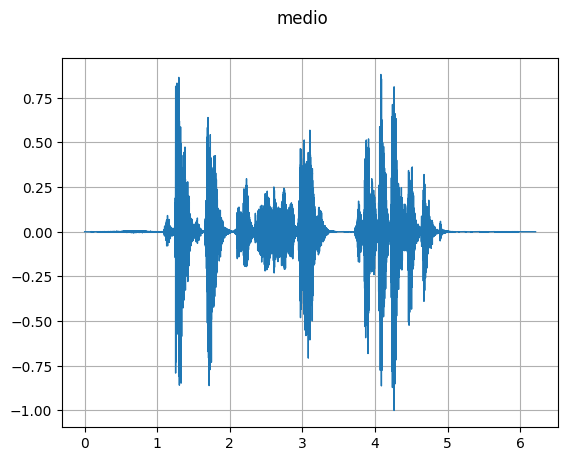

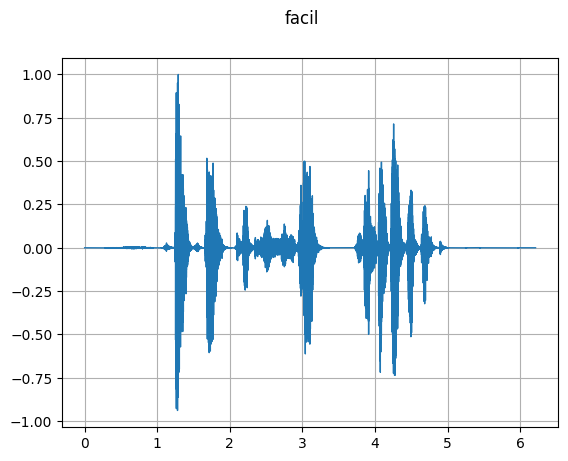

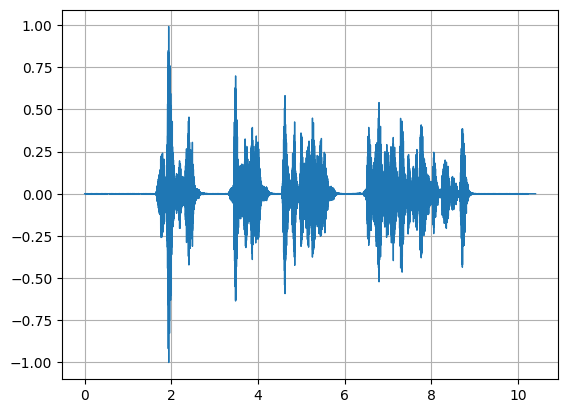

In [6]:
import torchaudio
import torch
rir_raw, rir_sample_rate = torchaudio.load("medio.wav")
plot_waveform(rir_raw, rir_sample_rate, title="medio")
rir_raw, rir_sample_rate = torchaudio.load("facil.wav")
plot_waveform(rir_raw, rir_sample_rate, title="facil")
rir_raw, rir_sample_rate = torchaudio.load("upc_ca_pau_101027aghajghkdjghk.wav")
plot_waveform(rir_raw, rir_sample_rate, title="")

In [12]:
import torchaudio.functional as F

input_filename = "upc_ca_ona_100000.wav"
rir_filepath = "../program_samples/real_rirs_isotropic_noises/air_type1_air_binaural_lecture_1_6.wav"
output_filename = "upc_ca_ona_100000RIR.wav"

waveform, sample_rate = torchaudio.load(input_filename)
#plot_waveform(waveform, sample_rate, title="Original")
#plot_specgram(waveform, sample_rate, title="Original")



rir_raw, rir_sample_rate = torchaudio.load(rir_filepath)
#plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)")
#plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")

rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)

#plot_waveform(rir, sample_rate, title="Room Impulse Response fixed")
#plot_specgram(rir, sample_rate, title="Room Impulse Response fixed")

# If the RIR file has a different sample rate, resample it
if rir_sample_rate != sample_rate:
    rir , _ = resample_audio(rir_filepath, sample_rate)
    #plot_waveform(rir, sample_rate, title="Room Impulse Response sampled")
    #plot_specgram(rir, sample_rate, title="Room Impulse Response sampled")


# Apply the RIR to the audio file
#augmented_waveform = torch.nn.functional.conv1d(waveform[None, :], rir_waveform[None, :])[0]

augmented_waveform = F.fftconvolve(waveform, rir)

#plot_waveform(augmented_waveform, sample_rate, title="Augmented")
#plot_specgram(augmented_waveform, sample_rate, title="Augmented")
# Save the augmented audio to the output file
torchaudio.save(output_filename, augmented_waveform, sample_rate)

In [7]:
torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


48000
16000
48000


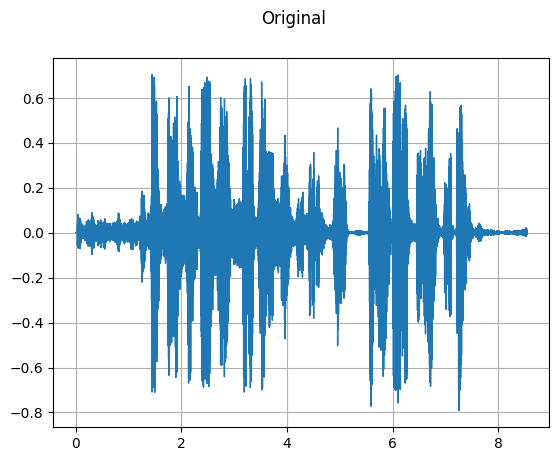

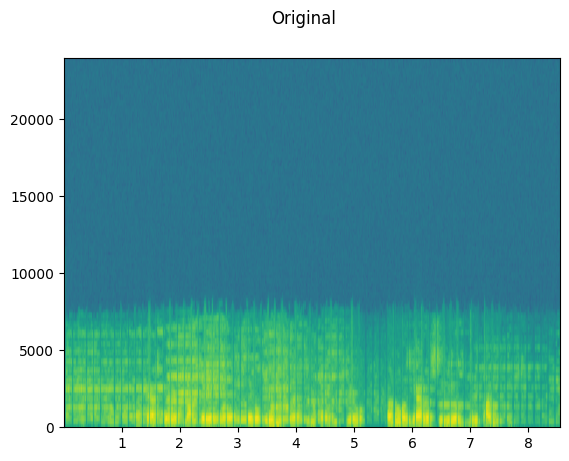

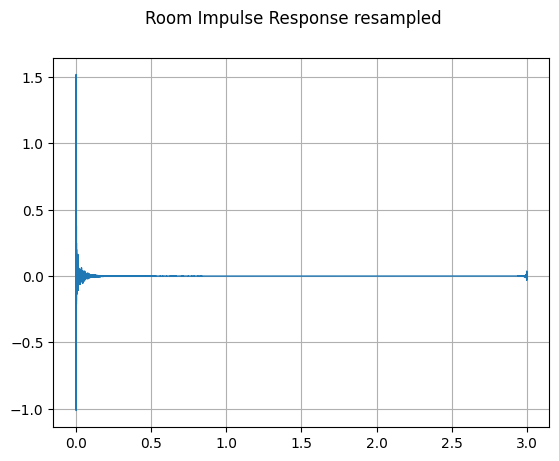

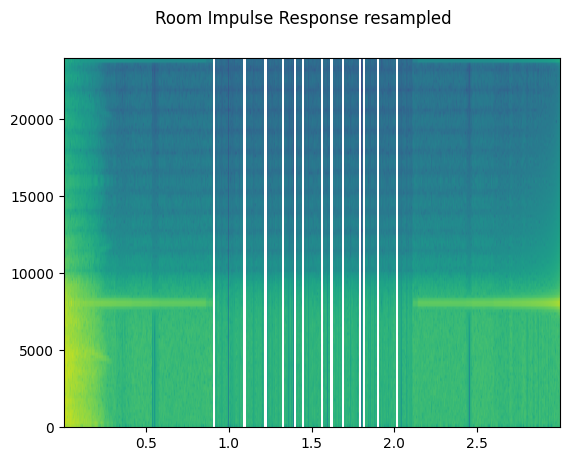

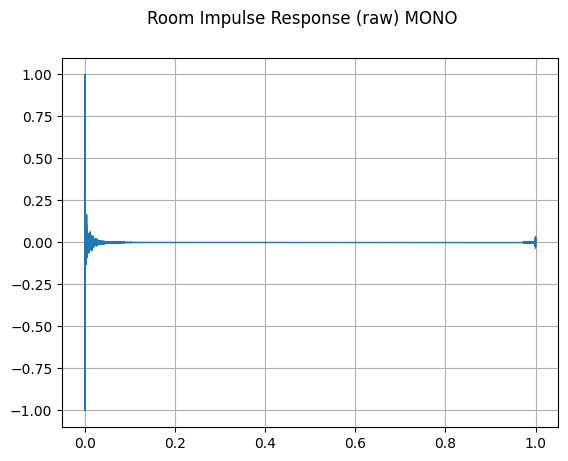

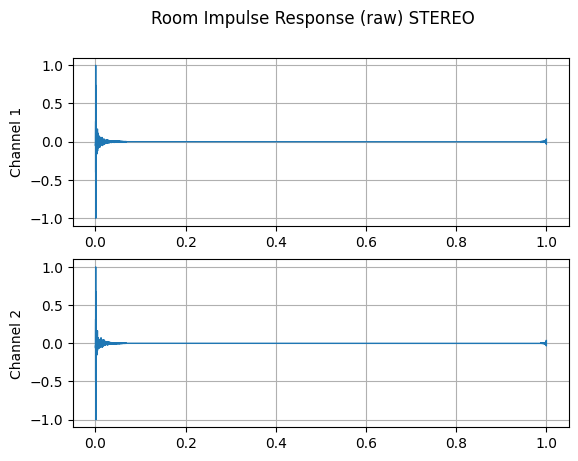

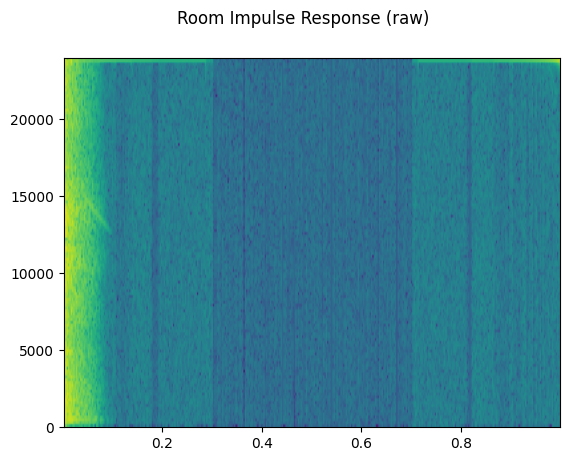

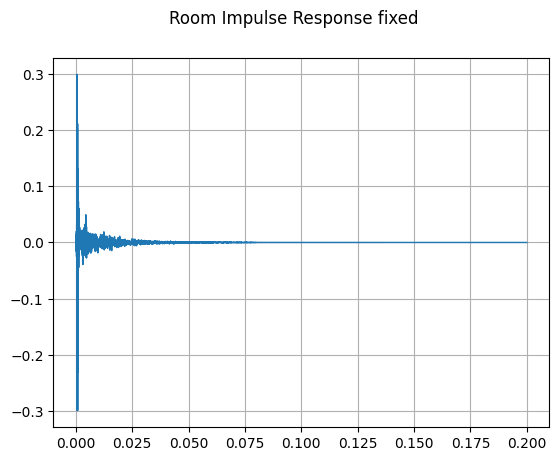

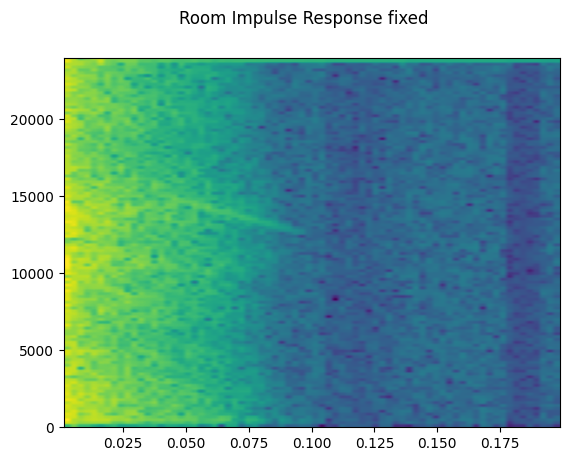

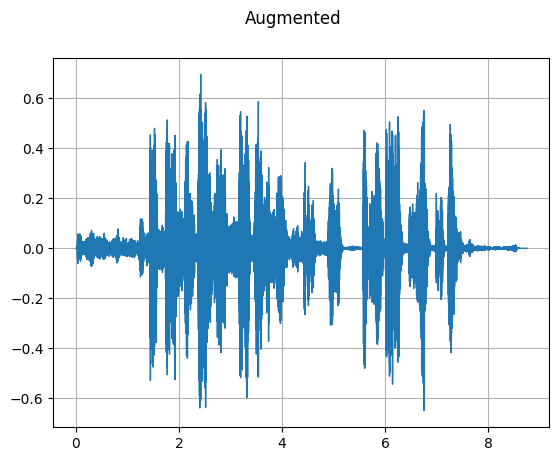

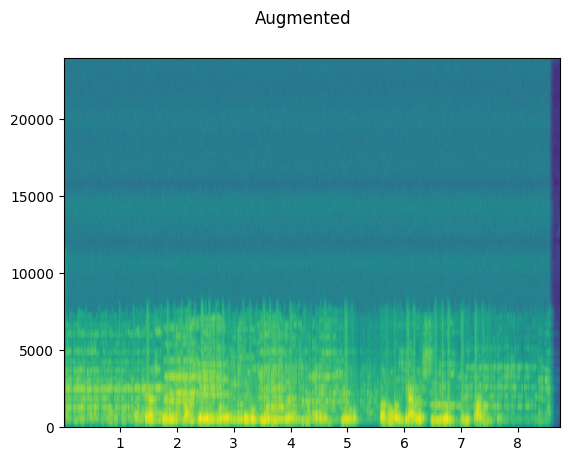

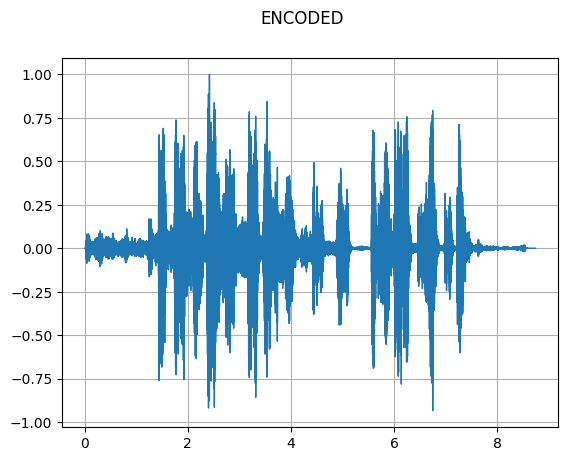

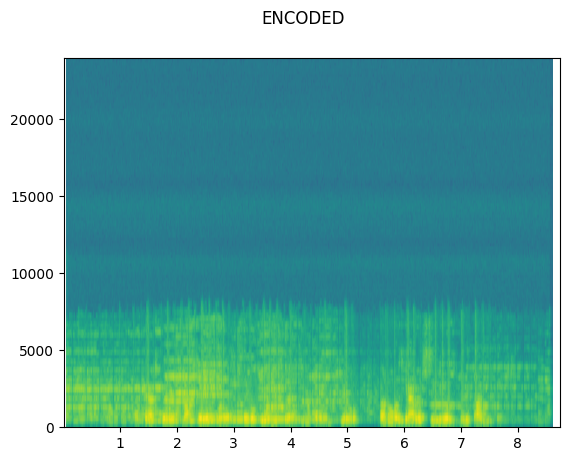

In [27]:
import torchaudio.functional as F
import torch
import torchaudio

import torchaudio
import torchaudio.functional as F

def resample_audio(input_filename, target_sample_rate):
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Load the audio file
    waveform, sample_rate = torchaudio.load(input_filename)
    #waveform = waveform.to(device)
    # Create a resample transform
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)

    # Apply the resample transform to the waveform
    resampled_waveform = resampler(waveform)

    return resampled_waveform, target_sample_rate




# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_filename = "../DATABASE/lt400small/common_voice_ca_19503277.wav"
rir_filepath = "../program_samples/AIR_Database_Mono/air_type1_air_phone_meeting_hfrp.wav"
output_filename = "upc_ca_ona_100000RIR.wav"

waveform, original_sample_rate = torchaudio.load(input_filename)
sample_rate = original_sample_rate
waveform = waveform.to(device)  # Move the waveform tensor to the GPU
plot_waveform(waveform.cpu(), sample_rate, title="Original")  # Move the tensor back to the CPU for plotting
plot_specgram(waveform.cpu(), sample_rate, title="Original")

rir_raw, rir_sample_rate = torchaudio.load(rir_filepath)

rir_raw = rir_raw.to(device)  # Move the RIR tensor to the GPU

rir_raw1, l = torchaudio.load("../program_samples/real_rirs_isotropic_noises/air_type1_air_phone_meeting_hfrp.wav")

if rir_sample_rate != sample_rate:
    rir , resample_rate = resample_audio(rir_filepath, sample_rate)
    print(resample_rate)
    rir = rir.to(device)  # Move the resampled RIR tensor to the GPU
    plot_waveform(rir.cpu(), sample_rate, title="Room Impulse Response resampled")
    plot_specgram(rir.cpu(), sample_rate, title="Room Impulse Response resampled")


plot_waveform(rir_raw.cpu(), sample_rate, title="Room Impulse Response (raw) MONO")
plot_waveform(rir_raw1.cpu(), sample_rate, title="Room Impulse Response (raw) STEREO")
plot_specgram(rir_raw.cpu(), sample_rate, title="Room Impulse Response (raw)")

rir = rir_raw[:, int(sample_rate * 0.00) : int(sample_rate * 0.2)]
#rir = rir / torch.linalg.vector_norm(rir, ord=2)


plot_waveform(rir.cpu(), sample_rate, title="Room Impulse Response fixed")
plot_specgram(rir.cpu(), sample_rate, title="Room Impulse Response fixed")

# If the RIR file has a different sample rate, resample it
print(rir_sample_rate)
print(sample_rate)

# Apply the RIR to the audio file
augmented_waveform = F.fftconvolve(waveform, rir)

plot_waveform(augmented_waveform.cpu(), sample_rate, title="Augmented")
plot_specgram(augmented_waveform.cpu(), sample_rate, title="Augmented")

# Save the augmented audio to the output file
# Normalize waveform to be between -1.0 and 1.0
normalized_waveform = augmented_waveform / torch.max(torch.abs(augmented_waveform))
torchaudio.save(output_filename, normalized_waveform.cpu(), original_sample_rate, encoding = "PCM_S", format="wav")
encoded_waveform, sample_rate = torchaudio.load(output_filename)

plot_waveform(encoded_waveform.cpu(), sample_rate, title="ENCODED")
plot_specgram(encoded_waveform.cpu(), sample_rate, title="ENCODED")


In [1]:
import torchaudio.functional as F
import torchaudio

def resample_audio(input_filename, target_sample_rate):
    # Load the audio file
    waveform, sample_rate = torchaudio.load(input_filename)

    # Create a resample transform
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)

    # Apply the resample transform to the waveform
    resampled_waveform = resampler(waveform)

    return resampled_waveform, target_sample_rate


def RIR_Filtering(input_filename, output_filename, rir_filepath):
    device = torch.device("cpu")#"cuda" if torch.cuda.is_available() else "cpu")

    waveform, sample_rate = torchaudio.load(input_filename)
    waveform = waveform.to(device)  # Move the waveform tensor to the GPU

    rir_raw, rir_sample_rate = torchaudio.load(rir_filepath)

    rir_raw = rir_raw.to(device)  # Move the RIR tensor to the GPU

    #Fix and normalize raw rir vector
    rir = rir_raw[:, int(sample_rate * 0.005) : int(sample_rate * 0.25)]
    rir = rir / torch.linalg.vector_norm(rir, ord=2)

    # If the RIR file has a different sample rate, resample it
    if rir_sample_rate != sample_rate:
        rir , _ = resample_audio(rir_filepath, sample_rate)
        rir = rir.to(device)  # Move the resampled RIR tensor to the GPU

    # Apply the RIR to the audio file
    augmented_waveform = F.fftconvolve(waveform, rir)
    #print("RIR FILTERING COMPLETED WITH FILE: " + str(rir_filepath)+ "TO FILE: " + str(output_filename)
    # Save the resulting noisy signal to a new audio file
    # Save the augmented audio to the output file
    torchaudio.save(output_filename, augmented_waveform.cpu(), sample_rate, encoding='PCM_S', bits_per_sample=16)  # Move the tensor back to the CPU for saving


In [3]:
import os
import glob
import random
import torch

input_folder = 'lt400'
output_folder = 'output_folder'
rir_folder = "../program_samples/real_rirs_isotropic_noises/"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


audio_files = [f for f in os.listdir(rir_folder) if f.endswith('.wav')]

# Check if you have at least 20 rirfiles, if not, use the length of the list
# to avoid IndexError.
num_files_to_select = min(40, len(audio_files))

# Select 20 random rirfiles from the list
selected_files = random.sample(audio_files, num_files_to_select)

base_output_folder = output_folder  # Save the original output folder path

for rir_files in selected_files:
    print("RIR FILE: " + str(rir_files))
    subfolder_path = os.path.join(base_output_folder, f'shift{rir_files}')  # Create a new path for the subfolder
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

    for file in glob.glob(os.path.join(input_folder, '*.wav')):
        output_filename = os.path.join(subfolder_path, os.path.basename(file))  # Use the new subfolder path
        rir_files_path = os.path.join(rir_folder, rir_files)
        RIR_Filtering(file, output_filename, rir_files_path )



RIR FILE: air_type1_air_binaural_lecture_1_6.wav
RIR FILE: air_type1_air_binaural_stairway_1_2_180.wav


KeyboardInterrupt: 

In [3]:
import os
import glob
import random
import torch
import torchaudio.functional as F
import torchaudio
from tqdm import tqdm

def resample_audio(input_filename, target_sample_rate):
    # Load the audio file
    waveform, sample_rate = torchaudio.load(input_filename)

    # Create a resample transform
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)

    # Apply the resample transform to the waveform
    resampled_waveform = resampler(waveform)

    return resampled_waveform, target_sample_rate


def RIR_Filtering(input_filename, output_filename, rir_filepath):
    device = torch.device("cpu")#"cuda" if torch.cuda.is_available() else "cpu")

    waveform, original_sample_rate = torchaudio.load(input_filename)
    #waveform = waveform.to(device)  # Move the waveform tensor to the GPU

    sample_rate = original_sample_rate

    rir_raw, rir_sample_rate = torchaudio.load(rir_filepath)

    #rir_raw = rir_raw.to(device)  # Move the RIR tensor to the GPU

    # If the RIR file has a different sample rate, resample it
    if rir_sample_rate != sample_rate:
        rir , _ = resample_audio(rir_filepath, sample_rate)
        rir = rir.to(device)  # Move the resampled RIR tensor to the GPU

    #Fix and normalize raw rir vector
    rir = rir_raw[:, int(sample_rate * 0.0) : int(sample_rate * 0.2)]
    rir = rir / torch.linalg.vector_norm(rir, ord=2)

    # Apply the RIR to the audio file
    augmented_waveform = F.fftconvolve(waveform, rir)
    #print("RIR FILTERING COMPLETED WITH FILE: " + str(rir_filepath)+ "TO FILE: " + str(output_filename)
    # Save the resulting noisy signal to a new audio file
    # Save the augmented audio to the output file
    normalized_waveform = augmented_waveform / torch.max(torch.abs(augmented_waveform))
    torchaudio.save(output_filename, normalized_waveform.cpu(), original_sample_rate, encoding = "PCM_S", format="wav")
    


input_folder = 'lt400small'
output_folder = 'output_folder'
rir_folder = "../program_samples/AIR_Database_Mono/"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


audio_files = [f for f in os.listdir(rir_folder) if f.endswith('.wav')]

# Check if you have at least 20 rirfiles, if not, use the length of the list
# to avoid IndexError.
num_files_to_select = min(5, len(audio_files))

# Select 20 random rirfiles from the list
selected_files = random.sample(audio_files, num_files_to_select)

total_augmentations = num_files_to_select * 400
base_output_folder = output_folder  # Save the original output folder path
progress_bar = tqdm(total=total_augmentations, desc="Augmenting", unit="file", position=0, leave=True)
for rir_files in selected_files:
    print("RIR FILE: " + str(rir_files))
    subfolder_path = os.path.join(base_output_folder, f'shift{rir_files}')  # Create a new path for the subfolder
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

    for file in glob.glob(os.path.join(input_folder, '*.wav')):
        output_filename = os.path.join(subfolder_path, os.path.basename(file))  # Use the new subfolder path
        rir_files_path = os.path.join(rir_folder, rir_files)
        RIR_Filtering(file, output_filename, rir_files_path )
        progress_bar.update(1)  # Update the progress bar
progress_bar.close()  # Close the progress bar when the process is complete



Augmenting:   0%|          | 0/2000 [00:00<?, ?file/s]

RIR FILE: air_type1_air_binaural_lecture_1_3.wav


Augmenting:   1%|          | 11/2000 [00:01<04:33,  7.27file/s]

RIR FILE: air_type1_air_binaural_stairway_1_2_45.wav


Augmenting:   1%|          | 21/2000 [00:03<04:23,  7.51file/s]

RIR FILE: air_type1_air_binaural_lecture_1_6.wav


Augmenting:   2%|▏         | 31/2000 [00:04<04:53,  6.72file/s]

RIR FILE: air_type1_air_phone_lecture1_hfrp.wav


Augmenting:   2%|▏         | 41/2000 [00:06<04:59,  6.54file/s]

RIR FILE: air_type1_air_binaural_aula_carolina_1_1_90_3.wav


Augmenting:   2%|▎         | 50/2000 [00:08<05:13,  6.21file/s]


In [4]:
import os
import wave
import json
from vosk import Model, KaldiRecognizer, SetLogLevel
import pandas as pd
import tqdm
from tqdm import tqdm
import csv
from pathlib import Path
from jiwer import wer
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from scipy.io import wavfile
import warnings
from pesq import cypesq
import torch
import librosa

def transcribe_files_to_tsv(input_folder, output_folder, output_filename):
   # Set the log level to 0 to disable debug messages
   SetLogLevel(-1)

   model = Model(lang="ca")
   transcriptions = []

   # Iterate through all files in the input folder
   for file in os.listdir(input_folder):
      #print(os.path.basename(file))
      if file.endswith(".wav"):
        #wf = wave.read("upc_ca_ona_100043.wav")
        wf = wave.open(os.path.join(input_folder, file))

        rec = KaldiRecognizer(model, wf.getframerate())
        rec.SetWords(True)
        rec.SetPartialWords(True)

        # Process the audio file
        second_last= None
        last = None
        currentpartial = None
        while True:
            data = wf.readframes(4000)
            if len(data) == 0:
                break     
            if rec.AcceptWaveform(data):
                if(last != None):
                    second_last = last
                last = rec.Result()
            else:
                currentpartial = rec.PartialResult()     
                #print(currentpartial)       
            #if rec.AcceptWaveform(data):


        result_json = rec.Result()
        try:
            dict_partial = json.loads(result_json)
        except:
            print("Error finding prediction for file: " + str(file))
        result_dict = dict_partial
        if(dict_partial["text"] == ""):
            try:
                if(last != None):
                    dict_last = json.loads(last) 
                else:
                    dict_last = {"text": ""}
                if(second_last != None):
                    dict_second_last = json.loads(second_last)
                else:
                    dict_second_last = {"text": ""}
                if(len(dict_last["text"]) >= len(dict_second_last["text"])):
                    result_dict = dict_last
                elif(len(dict_last["text"]) < len(dict_second_last["text"])):
                    result_dict = dict_second_last
            except:
                print("Error!") 

        #print(result_dict["text"])
        transcriptions.append((os.path.basename(file), result_dict["text"]))

   # Convert the list of transcriptions to a DataFrame
   transcriptions_df = pd.DataFrame(transcriptions, columns=['filename', 'transcription'])

   # Save the output to a TSV file
   output_file_path = os.path.join(output_folder, output_filename)
   transcriptions_df.to_csv(output_file_path, sep="\t", index=False)
   print("TRANSCRIPT DONE FILE SAVED IN FILE: " + str(output_file_path))


# Suppress the specific warning messages
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).")

def read_audio_file(file_path):
    data, fs = librosa.load(file_path, sr=16000)
    data = torch.tensor(data, dtype=torch.float32)
    return fs, data

def calculate_pesq(fs, ref_audio, deg_audio, mode):
    # Detach the tensors from the computation graph and move them to the CPU
    ref_audio_detached = ref_audio.detach().cpu()
    deg_audio_detached = deg_audio.detach().cpu()
    
    try:
        # Call the perceptual_evaluation_speech_quality function with PyTorch tensors
        return perceptual_evaluation_speech_quality(ref_audio_detached, deg_audio_detached, fs, mode)
    except cypesq.NoUtterancesError:
        print("No utterances detected in the input audio files.")
        return 1

def pesq_from_paths(ref_file_path, deg_file_path):
    fs_ref, ref_audio = read_audio_file(ref_file_path)
    fs_deg, deg_audio = read_audio_file(deg_file_path)
    # Ensure the sampling frequencies are the same
    assert fs_ref == fs_deg, "Sampling frequencies must be the same" + str(fs_ref) + str(fs_deg)

    # Choose the mode based on the sampling frequency
    mode = 'wb' if fs_ref == 16000 else 'nb'

    if len(ref_audio) > len(deg_audio):
        pad_length = len(ref_audio) - len(deg_audio)
        deg_audio = torch.cat([deg_audio, torch.zeros(pad_length, dtype=torch.float32)])
    elif len(ref_audio) < len(deg_audio):
        deg_audio = deg_audio[:len(ref_audio)]

    # Calculate PESQ score
    pesq_score = calculate_pesq(fs_ref, ref_audio, deg_audio, mode)
    return pesq_score

def read_tsv_file(tsv_file_path):
    # Read the TSV file and store its contents in a dictionary
    tsv_data = {}

    with open(tsv_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        next(tsv_file)  # Skip header row
        for line in tsv_file:
            if len(line) == 2:
                filename, transcription = line
                tsv_data[filename] = {
                    "transcription": transcription
                }
            else:
                print(f"Skipping line with unexpected number of values: {line}")

    return tsv_data

ORIGINAL_FOLDER = "lt400"

def calculate_wer_pesq(original_data, augmented_data,og_path,augmented_data_path, output_file_path, folder):
    # Calculate WER and PESQ for each file
    output = []
    for filename, data in original_data.items():
        original_transcription = data["transcription"]
        if filename in augmented_data:
            augmented_transcription = augmented_data[filename]["transcription"]
            ref_file_path = f"{og_path}/{filename}"
            deg_file_path = f"{augmented_data_path}/{filename}"
            print(ref_file_path + "  " + deg_file_path)
            try:
                wer_score = wer(original_transcription, augmented_transcription)
            except:
                wer_score = 1
            pesq_score = pesq_from_paths(ref_file_path, deg_file_path)
            #print("PESQ "+ str(pesq_score)+"WER "+str(wer_score))
            output.append([filename, wer_score, str(pesq_score).replace("tensor(", "").replace(")", ""), folder])
        else:
            print(f"No augmented transcription found for file {filename}")
    # Save the output to a TSV file
    with open(output_file_path, "w", newline="") as file:
        writer = csv.writer(file, delimiter="\t")
        writer.writerow(["Filename", "WER", "PESQ", "filename"])
        writer.writerows(output)




from pydub import AudioSegment

file_path = "upc_ca_ona_100000.wav"

# Load the audio file
audio = AudioSegment.from_file(file_path)

# Get the audio file format
audio_format = audio.sample_width * 8  # bits per sample
print(f"Audio format: {audio_format} bits per sample")


directory_path = "output_folder"
all_items = os.listdir(directory_path)
# Filter out only the folders
folder_names = [item for item in all_items if os.path.isdir(os.path.join(directory_path, item))]
print(folder_names)


tsvoriginal_file_path = Path("lt400small/lt400.tsv")
tsv_data = read_tsv_file(tsvoriginal_file_path)
original_data_path = "lt400"
progress_bar = tqdm(total=len(folder_names), desc="Augmenting", unit="file", position=0, leave=True)
for folder in folder_names:
    print(str(folder))
    output_folder = os.path.join(directory_path)
    transcribe_files_to_tsv(directory_path+"/"+folder, directory_path, os.path.join(folder+".tsv"))
    augmented_tsv = read_tsv_file(os.path.join(directory_path+"/"+folder+".tsv"))
    calculate_wer_pesq(tsv_data, augmented_tsv, original_data_path, directory_path +"/"+ folder, Path(output_folder+"/"+folder+"OUTPUT.tsv"),folder)
    progress_bar.update(1)  # Update the progress bar
progress_bar.close()  # Close the progress bar when the process is complete

a

Audio format: 16 bits per sample
['shiftair_type1_air_binaural_stairway_1_1_90.wav', 'shiftair_type1_air_binaural_stairway_1_2_45.wav', 'shiftair_type1_air_binaural_stairway_1_1_150.wav', 'shiftair_type1_air_binaural_lecture_1_4.wav', 'shiftair_type1_air_binaural_aula_carolina_1_1_90_3.wav', 'shiftair_type1_air_phone_lecture1_hfrp.wav', 'shiftair_type1_air_binaural_lecture_1_6.wav', 'shiftair_type1_air_binaural_stairway_1_1_30.wav', 'shiftair_type1_air_binaural_stairway_1_2_75.wav', 'shiftair_type1_air_binaural_lecture_1_3.wav']


Augmenting:   0%|          | 0/10 [00:00<?, ?file/s]

shiftair_type1_air_binaural_stairway_1_1_90.wav
TRANSCRIPT DONE FILE SAVED IN FILE: output_folder/shiftair_type1_air_binaural_stairway_1_1_90.wav.tsv
lt400/common_voice_ca_17852479.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_90.wav/common_voice_ca_17852479.wav
lt400/common_voice_ca_18179316.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_90.wav/common_voice_ca_18179316.wav
lt400/common_voice_ca_18489699.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_90.wav/common_voice_ca_18489699.wav
lt400/common_voice_ca_18489700.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_90.wav/common_voice_ca_18489700.wav
lt400/common_voice_ca_19034690.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_90.wav/common_voice_ca_19034690.wav
lt400/common_voice_ca_19290202.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_90.wav/common_voice_ca_19290202.wav
lt400/common_voice_ca_19503277.wav  output_folder/shiftair_type1_air_binaural_stairway_1

Augmenting:  10%|█         | 1/10 [00:15<02:18, 15.38s/file]

shiftair_type1_air_binaural_stairway_1_2_45.wav
TRANSCRIPT DONE FILE SAVED IN FILE: output_folder/shiftair_type1_air_binaural_stairway_1_2_45.wav.tsv
lt400/common_voice_ca_17852479.wav  output_folder/shiftair_type1_air_binaural_stairway_1_2_45.wav/common_voice_ca_17852479.wav
lt400/common_voice_ca_18179316.wav  output_folder/shiftair_type1_air_binaural_stairway_1_2_45.wav/common_voice_ca_18179316.wav
lt400/common_voice_ca_18489699.wav  output_folder/shiftair_type1_air_binaural_stairway_1_2_45.wav/common_voice_ca_18489699.wav
lt400/common_voice_ca_18489700.wav  output_folder/shiftair_type1_air_binaural_stairway_1_2_45.wav/common_voice_ca_18489700.wav
lt400/common_voice_ca_19034690.wav  output_folder/shiftair_type1_air_binaural_stairway_1_2_45.wav/common_voice_ca_19034690.wav
lt400/common_voice_ca_19290202.wav  output_folder/shiftair_type1_air_binaural_stairway_1_2_45.wav/common_voice_ca_19290202.wav
lt400/common_voice_ca_19503277.wav  output_folder/shiftair_type1_air_binaural_stairway_1

Augmenting:  20%|██        | 2/10 [00:29<01:58, 14.75s/file]

shiftair_type1_air_binaural_stairway_1_1_150.wav
TRANSCRIPT DONE FILE SAVED IN FILE: output_folder/shiftair_type1_air_binaural_stairway_1_1_150.wav.tsv
lt400/common_voice_ca_17852479.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_150.wav/common_voice_ca_17852479.wav
lt400/common_voice_ca_18179316.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_150.wav/common_voice_ca_18179316.wav
lt400/common_voice_ca_18489699.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_150.wav/common_voice_ca_18489699.wav
lt400/common_voice_ca_18489700.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_150.wav/common_voice_ca_18489700.wav
lt400/common_voice_ca_19034690.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_150.wav/common_voice_ca_19034690.wav
lt400/common_voice_ca_19290202.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_150.wav/common_voice_ca_19290202.wav
lt400/common_voice_ca_19503277.wav  output_folder/shiftair_type1_air_binaural_st

Augmenting:  30%|███       | 3/10 [00:43<01:40, 14.33s/file]

shiftair_type1_air_binaural_lecture_1_4.wav


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.


TRANSCRIPT DONE FILE SAVED IN FILE: output_folder/shiftair_type1_air_binaural_lecture_1_4.wav.tsv
lt400/common_voice_ca_17852479.wav  output_folder/shiftair_type1_air_binaural_lecture_1_4.wav/common_voice_ca_17852479.wav
lt400/common_voice_ca_18179316.wav  output_folder/shiftair_type1_air_binaural_lecture_1_4.wav/common_voice_ca_18179316.wav
lt400/common_voice_ca_18489699.wav  output_folder/shiftair_type1_air_binaural_lecture_1_4.wav/common_voice_ca_18489699.wav
lt400/common_voice_ca_18489700.wav  output_folder/shiftair_type1_air_binaural_lecture_1_4.wav/common_voice_ca_18489700.wav
lt400/common_voice_ca_19034690.wav  output_folder/shiftair_type1_air_binaural_lecture_1_4.wav/common_voice_ca_19034690.wav
lt400/common_voice_ca_19290202.wav  output_folder/shiftair_type1_air_binaural_lecture_1_4.wav/common_voice_ca_19290202.wav
lt400/common_voice_ca_19503277.wav  output_folder/shiftair_type1_air_binaural_lecture_1_4.wav/common_voice_ca_19503277.wav
lt400/common_voice_ca_19908846.wav  outpu

Augmenting:  40%|████      | 4/10 [00:57<01:25, 14.21s/file]

shiftair_type1_air_binaural_aula_carolina_1_1_90_3.wav


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

TRANSCRIPT DONE FILE SAVED IN FILE: output_folder/shiftair_type1_air_binaural_aula_carolina_1_1_90_3.wav.tsv
lt400/common_voice_ca_17852479.wav  output_folder/shiftair_type1_air_binaural_aula_carolina_1_1_90_3.wav/common_voice_ca_17852479.wav
lt400/common_voice_ca_18179316.wav  output_folder/shiftair_type1_air_binaural_aula_carolina_1_1_90_3.wav/common_voice_ca_18179316.wav
lt400/common_voice_ca_18489699.wav  output_folder/shiftair_type1_air_binaural_aula_carolina_1_1_90_3.wav/common_voice_ca_18489699.wav
lt400/common_voice_ca_18489700.wav  output_folder/shiftair_type1_air_binaural_aula_carolina_1_1_90_3.wav/common_voice_ca_18489700.wav
lt400/common_voice_ca_19034690.wav  output_folder/shiftair_type1_air_binaural_aula_carolina_1_1_90_3.wav/common_voice_ca_19034690.wav
lt400/common_voice_ca_19290202.wav  output_folder/shiftair_type1_air_binaural_aula_carolina_1_1_90_3.wav/common_voice_ca_19290202.wav
lt400/common_voice_ca_19503277.wav  output_folder/shiftair_type1_air_binaural_aula_caro

Augmenting:  50%|█████     | 5/10 [01:11<01:09, 13.97s/file]

shiftair_type1_air_phone_lecture1_hfrp.wav


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

TRANSCRIPT DONE FILE SAVED IN FILE: output_folder/shiftair_type1_air_phone_lecture1_hfrp.wav.tsv
lt400/common_voice_ca_17852479.wav  output_folder/shiftair_type1_air_phone_lecture1_hfrp.wav/common_voice_ca_17852479.wav
lt400/common_voice_ca_18179316.wav  output_folder/shiftair_type1_air_phone_lecture1_hfrp.wav/common_voice_ca_18179316.wav
lt400/common_voice_ca_18489699.wav  output_folder/shiftair_type1_air_phone_lecture1_hfrp.wav/common_voice_ca_18489699.wav
lt400/common_voice_ca_18489700.wav  output_folder/shiftair_type1_air_phone_lecture1_hfrp.wav/common_voice_ca_18489700.wav
lt400/common_voice_ca_19034690.wav  output_folder/shiftair_type1_air_phone_lecture1_hfrp.wav/common_voice_ca_19034690.wav
lt400/common_voice_ca_19290202.wav  output_folder/shiftair_type1_air_phone_lecture1_hfrp.wav/common_voice_ca_19290202.wav
lt400/common_voice_ca_19503277.wav  output_folder/shiftair_type1_air_phone_lecture1_hfrp.wav/common_voice_ca_19503277.wav
lt400/common_voice_ca_19908846.wav  output_folder

Augmenting:  60%|██████    | 6/10 [01:24<00:55, 13.94s/file]

shiftair_type1_air_binaural_lecture_1_6.wav


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

TRANSCRIPT DONE FILE SAVED IN FILE: output_folder/shiftair_type1_air_binaural_lecture_1_6.wav.tsv
lt400/common_voice_ca_17852479.wav  output_folder/shiftair_type1_air_binaural_lecture_1_6.wav/common_voice_ca_17852479.wav
lt400/common_voice_ca_18179316.wav  output_folder/shiftair_type1_air_binaural_lecture_1_6.wav/common_voice_ca_18179316.wav
lt400/common_voice_ca_18489699.wav  output_folder/shiftair_type1_air_binaural_lecture_1_6.wav/common_voice_ca_18489699.wav
lt400/common_voice_ca_18489700.wav  output_folder/shiftair_type1_air_binaural_lecture_1_6.wav/common_voice_ca_18489700.wav
lt400/common_voice_ca_19034690.wav  output_folder/shiftair_type1_air_binaural_lecture_1_6.wav/common_voice_ca_19034690.wav
lt400/common_voice_ca_19290202.wav  output_folder/shiftair_type1_air_binaural_lecture_1_6.wav/common_voice_ca_19290202.wav
lt400/common_voice_ca_19503277.wav  output_folder/shiftair_type1_air_binaural_lecture_1_6.wav/common_voice_ca_19503277.wav
lt400/common_voice_ca_19908846.wav  outpu

Augmenting:  70%|███████   | 7/10 [01:38<00:41, 13.89s/file]

shiftair_type1_air_binaural_stairway_1_1_30.wav


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.


TRANSCRIPT DONE FILE SAVED IN FILE: output_folder/shiftair_type1_air_binaural_stairway_1_1_30.wav.tsv
lt400/common_voice_ca_17852479.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_30.wav/common_voice_ca_17852479.wav
lt400/common_voice_ca_18179316.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_30.wav/common_voice_ca_18179316.wav
lt400/common_voice_ca_18489699.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_30.wav/common_voice_ca_18489699.wav
lt400/common_voice_ca_18489700.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_30.wav/common_voice_ca_18489700.wav
lt400/common_voice_ca_19034690.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_30.wav/common_voice_ca_19034690.wav
lt400/common_voice_ca_19290202.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_30.wav/common_voice_ca_19290202.wav
lt400/common_voice_ca_19503277.wav  output_folder/shiftair_type1_air_binaural_stairway_1_1_30.wav/common_voice_ca_19503277.wav
lt400/com

Augmenting:  80%|████████  | 8/10 [01:51<00:27, 13.67s/file]

shiftair_type1_air_binaural_stairway_1_2_75.wav
TRANSCRIPT DONE FILE SAVED IN FILE: output_folder/shiftair_type1_air_binaural_stairway_1_2_75.wav.tsv
lt400/common_voice_ca_17852479.wav  output_folder/shiftair_type1_air_binaural_stairway_1_2_75.wav/common_voice_ca_17852479.wav
lt400/common_voice_ca_18179316.wav  output_folder/shiftair_type1_air_binaural_stairway_1_2_75.wav/common_voice_ca_18179316.wav
lt400/common_voice_ca_18489699.wav  output_folder/shiftair_type1_air_binaural_stairway_1_2_75.wav/common_voice_ca_18489699.wav
lt400/common_voice_ca_18489700.wav  output_folder/shiftair_type1_air_binaural_stairway_1_2_75.wav/common_voice_ca_18489700.wav
lt400/common_voice_ca_19034690.wav  output_folder/shiftair_type1_air_binaural_stairway_1_2_75.wav/common_voice_ca_19034690.wav
lt400/common_voice_ca_19290202.wav  output_folder/shiftair_type1_air_binaural_stairway_1_2_75.wav/common_voice_ca_19290202.wav
lt400/common_voice_ca_19503277.wav  output_folder/shiftair_type1_air_binaural_stairway_1

Augmenting:  90%|█████████ | 9/10 [02:06<00:13, 13.98s/file]

shiftair_type1_air_binaural_lecture_1_3.wav
TRANSCRIPT DONE FILE SAVED IN FILE: output_folder/shiftair_type1_air_binaural_lecture_1_3.wav.tsv
lt400/common_voice_ca_17852479.wav  output_folder/shiftair_type1_air_binaural_lecture_1_3.wav/common_voice_ca_17852479.wav
lt400/common_voice_ca_18179316.wav  output_folder/shiftair_type1_air_binaural_lecture_1_3.wav/common_voice_ca_18179316.wav
lt400/common_voice_ca_18489699.wav  output_folder/shiftair_type1_air_binaural_lecture_1_3.wav/common_voice_ca_18489699.wav
lt400/common_voice_ca_18489700.wav  output_folder/shiftair_type1_air_binaural_lecture_1_3.wav/common_voice_ca_18489700.wav
lt400/common_voice_ca_19034690.wav  output_folder/shiftair_type1_air_binaural_lecture_1_3.wav/common_voice_ca_19034690.wav
lt400/common_voice_ca_19290202.wav  output_folder/shiftair_type1_air_binaural_lecture_1_3.wav/common_voice_ca_19290202.wav
lt400/common_voice_ca_19503277.wav  output_folder/shiftair_type1_air_binaural_lecture_1_3.wav/common_voice_ca_19503277.w

Augmenting: 100%|██████████| 10/10 [02:20<00:00, 14.07s/file]


In [11]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

def plot_wer_pesq(output_file_paths):
    grouped_data = {}
    
    for output_file_path in output_file_paths:
        with open(output_file_path, "r") as file:
            tsv_file = csv.reader(file, delimiter="\t")
            header = next(tsv_file)
            for line in tsv_file:
                clip = str(line[3])
                wer = float(line[1])
                pesq = float(line[2])
                
                if clip not in grouped_data:
                    grouped_data[clip] = {'WER': [], 'PESQ': []}
                
                grouped_data[clip]['WER'].append(wer) 
                grouped_data[clip]['PESQ'].append(pesq)
    
    clip_levels = sorted(grouped_data.keys())
    rgb_values = sns.color_palette("husl", len(clip_levels))
    clip_colors = dict(zip(clip_levels, rgb_values))

    # Define custom colors for each clip level
    X_colors = {
        1: '#4AFF68',
        5: '#4AFF68',
        10: '#FFAE0A',
        20: '#FFAE0A',
        30: '#FA1919',
        40: '#FA1919'
    }

    plt.figure()

    plt.figure(figsize=(12, 8))
    
    avg_values = []

    for clip, data in grouped_data.items():
        wer = np.array(data['WER'])
        pesq = np.array(data['PESQ'])
        avg_wer = np.mean(wer)
        avg_pesq = np.mean(pesq)
        
        plt.scatter(pesq, wer, c=[clip_colors[clip]] * len(wer), label=f'clip {clip}', s=10, zorder=1)
        plt.scatter(avg_pesq, avg_wer, facecolors=[X_colors[clip]], marker='x', s=400, zorder=2, linewidths=3, edgecolors='black')
        plt.text(avg_pesq , avg_wer, f' clip: {clip}', fontsize=11, fontweight='bold', verticalalignment='bottom', zorder=3)
        avg_values.append((clip, avg_pesq, avg_wer))

    plt.xlabel("PESQ")
    plt.ylabel("WER")
    plt.ylim(0,1)
    plt.title("WER vs. PESQ")
    
    legend_elements = [
        plt.Line2D(
            [0], [0], marker='o', color='w', label=f'clip {x[0]} (avg PESQ: {x[1]:.2f}, avg WER: {x[2]:.2f})', 
            markerfacecolor=clip_colors[x[0]], markersize=10
        ) for x in avg_values
    ]

    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.0, 1.0))
    plt.show()


folder_path = 'output_folder'
output_file_paths = []

for filename in os.listdir(folder_path):
    if "OUTPUT" in filename:
        full_path = os.path.join(folder_path, filename)
        output_file_paths.append(full_path)

print(output_file_paths)



plot_wer_pesq(output_file_paths)


['output_folder/shiftair_type1_air_binaural_stairway_1_1_45.wavOUTPUT.tsv', 'output_folder/shiftair_type1_air_binaural_stairway_1_3_90.wavOUTPUT.tsv']


ValueError: could not convert string to float: 'shiftair_type1_air_binaural_stairway_1_1_45.wav'

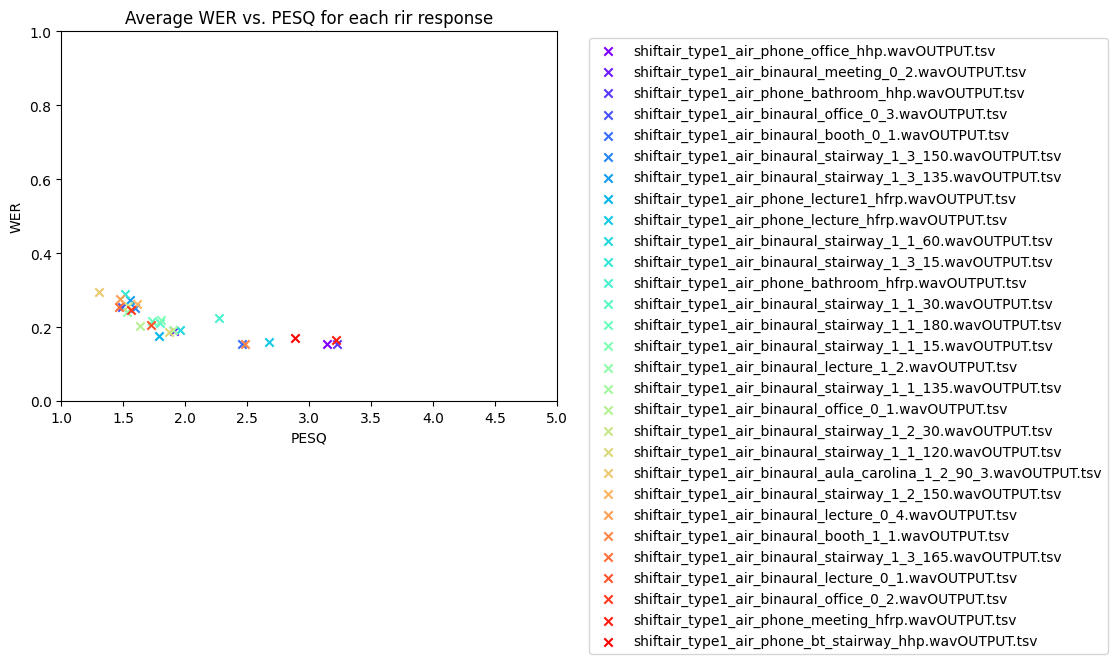

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_avg_values(directory):
    files = [f for f in os.listdir(directory) if 'OUTPUT' in f]
    avg_wer = []
    avg_pesq = []
    rir_responses = []

    for file in files:
        df = pd.read_csv(os.path.join(directory, file), sep='\t')
        avg_wer.append(df['WER'].mean())
        avg_pesq.append(df['PESQ'].mean())
        rir_responses.append(file)

    colors = plt.cm.rainbow(np.linspace(0, 1, len(files)))

    for i in range(len(files)):
        plt.scatter(avg_pesq[i], avg_wer[i], color=colors[i], marker='x', label=rir_responses[i])
        
    plt.title('Average WER vs. PESQ for each rir response')
    plt.xlabel('PESQ')
    plt.ylabel('WER')
    plt.xlim(1, 5)
    plt.ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Call the function with the directory containing the TSV files
plot_avg_values('finaltest/')


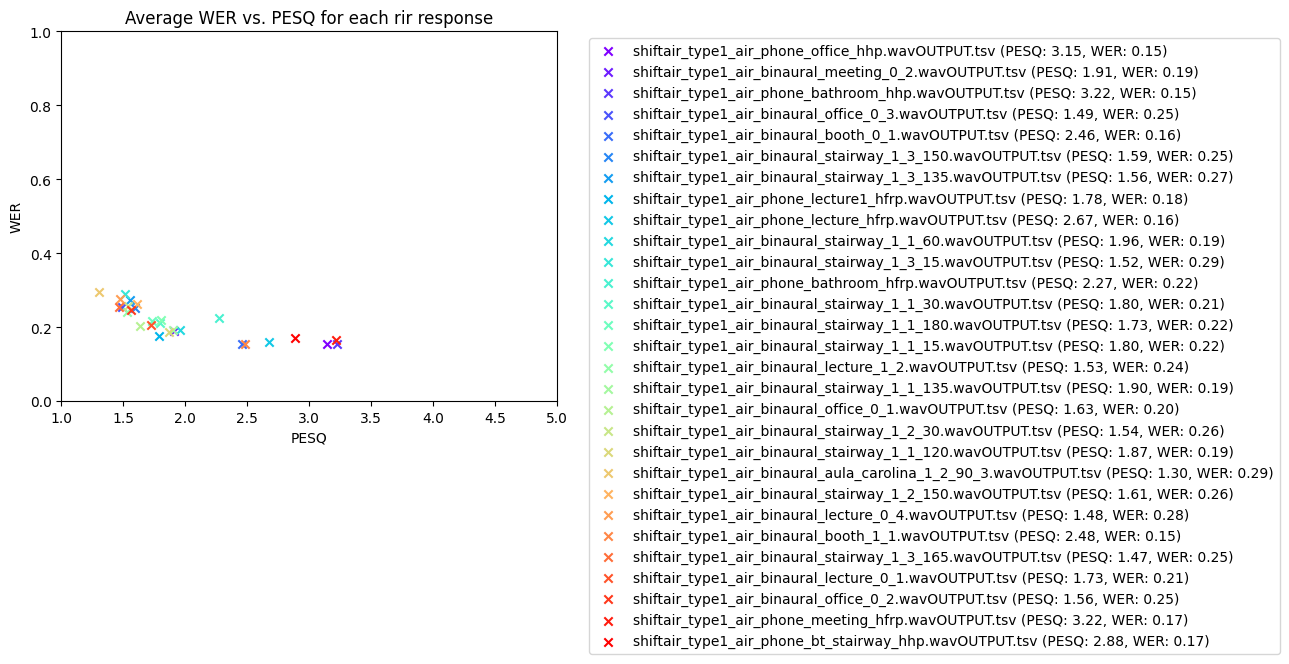

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_avg_values(directory):
    files = [f for f in os.listdir(directory) if 'OUTPUT' in f]
    avg_wer = []
    avg_pesq = []
    rir_responses = []

    for file in files:
        df = pd.read_csv(os.path.join(directory, file), sep='\t')
        avg_wer.append(df['WER'].mean())
        avg_pesq.append(df['PESQ'].mean())
        rir_responses.append(file)

    colors = plt.cm.rainbow(np.linspace(0, 1, len(files)))

    for i in range(len(files)):
        # Update label with mean PESQ and WER
        label = f'{rir_responses[i]} (PESQ: {avg_pesq[i]:.2f}, WER: {avg_wer[i]:.2f})'
        plt.scatter(avg_pesq[i], avg_wer[i], color=colors[i], marker='x', label=label)

    plt.title('Average WER vs. PESQ for each rir response')
    plt.xlabel('PESQ')
    plt.ylabel('WER')
    plt.xlim(1, 5)
    plt.ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Call the function with the directory containing the TSV files
plot_avg_values('finaltest/')
